In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Jensen & Rizzo (2007): doi:10.1088/1741-2560/4/1/S01.

In [2]:
# Data extracted from Fig. 2
jensen2007 = dict()

jensen2007['amp2amp1'] = np.array([0.98021, 0.06501, 1.96095, 0.22681,
                                   2.84399, 0.60933, 3.79513, 0.61970,
                                   4.63264, 0.68464, 5.43022, 0.78494,
                                   6.42094, 0.86290, 7.32954, 0.93068,
                                   8.28541, 1.00133]).reshape((-1, 2))
jensen2007['amp2amp1'][:, 0] = 1000.0 / np.array([15, 25, 40, 65, 100, 150, 250, 400, 650])

jensen2007['norm_resp'] = dict()
jensen2007['norm_resp']['1.5'] = np.array([1.11538, 0.99233, 2.13305, 0.99832,
                                           3.13831, 1.02989, 4.15798, 1.04791,
                                           5.13079, 0.98479, 6.14069, 0.94417,
                                           7.15497, 1.02987, 8.15510, 0.93062,
                                           9.17001, 0.92007, 10.19143, 0.94861]).reshape((-1, 2))
jensen2007['norm_resp']['2.5'] = np.array([1.13180, 0.99080, 2.14320, 0.95921,
                                           3.15460, 0.92761, 4.13668, 0.92012,
                                           5.14370, 0.96221, 6.17201, 0.93210,
                                           7.14858, 0.89153, 8.15184, 0.91107,
                                           9.14658, 0.87950, 10.18642, 0.91854]).reshape((-1, 2))
jensen2007['norm_resp']['4.0'] = np.array([1.11513, 0.99083, 2.11476, 0.88857,
                                           3.13192, 0.89156, 4.13781, 0.82689,
                                           5.09947, 0.79687, 6.16888, 0.81330,
                                           7.15397, 0.82385, 8.16349, 0.88098,
                                           9.13029, 0.78178, 10.18454, 0.80727]).reshape((-1, 2))
jensen2007['norm_resp']['6.5'] = np.array([1.14871, 0.99228, 2.10348, 0.82092,
                                           3.11313, 0.77880, 4.10010, 0.70063,
                                           5.12152, 0.72917, 6.13944, 0.73666,
                                           7.09584, 0.67507, 8.15184, 0.71107,
                                           9.13969, 0.73816, 10.14182, 0.65094]).reshape((-1, 2))
jensen2007['norm_resp']['10.0'] = np.array([1.14871, 0.99228, 2.12528, 0.75172,
                                            3.11000, 0.66001, 4.08294, 0.69764,
                                            5.12290, 0.63743, 6.12415, 0.64495,
                                            7.12365, 0.64194, 8.12065, 0.62390,
                                            9.10699, 0.64197, 10.12854, 0.57126]).reshape((-1, 2))
jensen2007['norm_resp']['15.0'] = np.array([1.13180, 0.99080, 2.08056, 0.58336,
                                            3.07204, 0.53225, 4.05700, 0.44204,
                                            5.08168, 0.49013, 6.07617, 0.45705,
                                            7.07141, 0.42849, 8.07930, 0.37585,
                                            9.04924, 0.39544, 10.08231, 0.39389]).reshape((-1, 2))
jensen2007['norm_resp']['25.0'] = np.array([1.11488, 0.98933, 2.08081, 0.58487,
                                            3.06176, 0.47061, 4.06703, 0.50218,
                                            5.09985, 0.49912, 6.05988, 0.35933,
                                            7.06139, 0.36835, 8.06640, 0.39842,
                                            9.05888, 0.35332, 10.08131, 0.38787]).reshape((-1, 2))
jensen2007['norm_resp']['40.0'] = np.array([1.11463, 0.98782, 2.00100, 0.20604,
                                            3.02694, 0.46164, 4.01090, 0.16542,
                                            5.06590, 0.39541, 5.98547, 0.11283,
                                            7.07880, 0.37284, 8.03170, 0.09020,
                                            9.06502, 0.29015, 10.04610, 0.07665]).reshape((-1, 2))
jensen2007['norm_resp']['65.0'] = np.array([1.13205, 0.99231, 1.99261, 0.05568,
                                            3.01002, 0.06016, 3.98910, 0.03463,
                                            5.03069, 0.08419, 6.00852, 0.05114,
                                            7.02180, 0.13082, 8.00000, 0.00003,
                                            9.00601, 0.03611, 10.01942, 0.01654]).reshape((-1, 2))

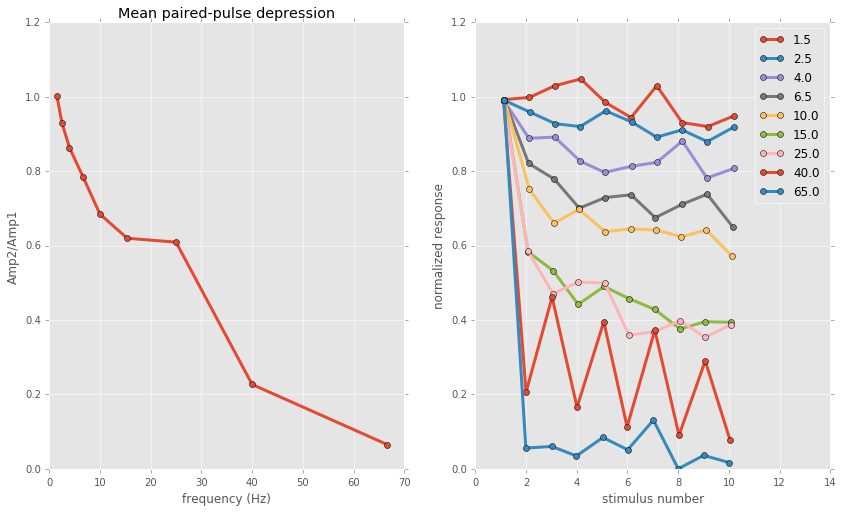

In [3]:
plt.figure(figsize=(14, 8))

plt.subplot(121)
plt.plot(jensen2007['amp2amp1'][:, 0], jensen2007['amp2amp1'][:, 1], 'o-', linewidth=3)
plt.xlabel('frequency (Hz)')
plt.ylabel('Amp2/Amp1')
plt.title('Mean paired-pulse depression')

plt.subplot(122)
for freq in [1.5, 2.5, 4, 6.5, 10, 15, 25, 40, 65]:
    cond = '%.1f' % freq
    plt.plot(jensen2007['norm_resp'][cond][:, 0], jensen2007['norm_resp'][cond][:, 1], 'o-', linewidth=3, label=cond)
plt.xlabel('stimulus number')
plt.ylabel('normalized response')
plt.xlim(0, 14)
plt.legend(loc='best')

In [4]:
# Data extracted from Fig. 1
cai2011 = dict()

cai2011['100'] = np.array([0.46257, 0.00105, 0.97908, 0.13688, 1.92488, 1.00413,
                           2.93725, 1.00626, 3.94948, 1.01050, 4.92435, 1.01255,
                           5.93659, 1.01679, 6.92409, 1.01676, 7.94909, 1.01681]).reshape((-1, 2))
cai2011['200'] = np.array([0.47507, 0.00108, 0.95816, 0.07157, 1.95514, 0.71998,
                           2.93725, 1.00626, 3.93698, 1.01047, 4.92448, 1.01045,
                           5.94922, 1.01471, 6.93646, 1.01889, 7.93672, 1.01468]).reshape((-1, 2))
cai2011['300'] = np.array([0.47507, 0.00108, 0.99671, 0.05481, 1.95487, 0.52419,
                           2.93225, 0.88625, 3.93856, 0.98521, 4.94948, 1.01050,
                           5.93672, 1.01468, 6.93672, 1.01468, 7.94909, 1.01681]).reshape((-1, 2))

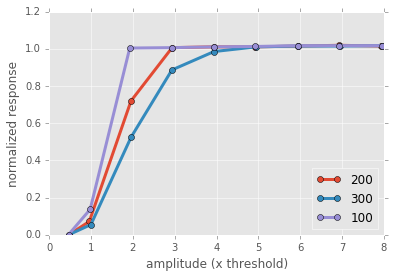

In [5]:
for cond in cai2011:
    plt.plot(cai2011[cond][:, 0], cai2011[cond][:, 1], 'o-', linewidth=3, label=cond)
plt.legend(loc='lower right')
plt.xlabel('amplitude (x threshold)')
plt.ylabel('normalized response')

# Model
-----------------

Following are all utily funcions used in this script.

In [6]:
class GanglionCell(object):
    def __init__(self, tsample, ca1_scale=1.0, ca1_tau=0.0191, ca2_scale=1.0, ca2_tau=14.0,
                 sig_a=3.0, sig_b=8.0):
        assert ca1_scale > 0
        assert ca2_scale > 0
        assert ca1_tau > 0
        assert ca2_tau >0
        self.ca1_tau = ca1_tau
        self.ca2_tau = ca2_tau
        self.ca1_scale = ca1_scale
        self.ca2_scale = ca2_scale
        self.tsample = tsample
        self.sig_a = sig_a
        self.sig_b = sig_b

        self.tau_nfl = 0.42 / 1000
        t = np.arange(0, 10 * self.tau_nfl, self.tsample)
        self.gamma_nfl = e2cm.gamma(1, self.tau_nfl, t)
        self.gamma_nfl /= np.trapz(self.gamma_nfl, dx=self.tsample)

        t = np.arange(0, 10 * self.ca1_tau, self.tsample)
        self.gamma_ca_fast = e2cm.gamma(1, self.ca1_tau, t)
        self.gamma_ca_fast /= np.trapz(self.gamma_ca_fast, dx=self.tsample)

#         t = np.arange(0, 10 * self.ca2_tau, self.tsample)
#         self.gamma_ca_slow = e2cm.gamma(1, self.ca2_tau, t)
#         self.gamma_ca_slow /= np.trapz(self.gamma_ca_slow, dx=self.tsample)

        
    def model_cascade(self, pt, dolayers=None, dojit=True):
        assert pt.tsample == self.tsample
        
        self.stim = pt
        self.ca_fast = pt.tsample * fftconvolve(np.abs(pt.data),
                                                  self.gamma_ca_fast, mode='full')[:pt.data.size]
#         self.ca_slow = pt.tsample * fftconvolve(np.abs(pt.data),
#                                                   self.gamma_ca_slow, mode='full')[:pt.data.size]

        self.r_impulse = pt.tsample * fftconvolve(pt.data, self.gamma_nfl)[:pt.data.size]
        
        self.r_adj = self.r_impulse - self.ca1_scale * self.ca_fast #- self.ca2_scale * self.ca_slow
        
        self.r_rgc = 100.0 / (1.0 + np.exp(-self.sig_a * self.r_adj + self.sig_b))
        
        return utils.TimeSeries(pt.tsample, self.r_rgc)

# Fit
----------

In [32]:
def run_jensen2007_exp0(model, amp=1.0):
    # Finding threshold
    freq = 10.0
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    num_pulses = 1
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp0 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.1,
                                  pulse_dur=pdur, interphase_dur=idur,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)
    exp0['gcr'] = gcr
    exp0['mov'] = mov
    exp0['resp'] = mov.data.max()
        
    return exp0

In [8]:
def run_jensen2007_exp1(model, isis=[15, 25, 40, 65, 100, 150, 250, 400, 650]):
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    amp = 1.5
    num_pulses = 2
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['isis'] = isis
    exp1['freqs'] = 1000.0 / np.array(isis)
    amp2amp1 = []
    for freq in exp1['freqs']:
        cond = '%.1f' % freq
        exp1[cond] = dict()
        
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                      pulse_dur=pdur, interphase_dur=idur,
                                      pulsetype='anodicfirst',
                                      delay=10.0 / 1000)
        mov = gcr.model_cascade(stim)
        exp1[cond]['gcr'] = gcr
        exp1[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp1[cond]['resp'] = peaks
        amp2amp1.append(peaks[1] / (peaks[0] + np.finfo(float).eps))
    exp1['amp2amp1'] = amp2amp1
        
    return exp1

In [9]:
def run_jensen2007_exp2(model, freqs=[1.5, 2.5, 4, 6.5, 10, 15, 25, 40, 65]):
    pdur = 1.0 / 1000
    idur = 0.5 / 1000
    amp = 1.5
    num_pulses = 10
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp2 = dict()
    exp2['freqs'] = freqs
    for freq in freqs:
        cond = '%.1f' % freq
        exp2[cond] = dict()
        
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                      pulse_dur=pdur, interphase_dur=idur,
                                      pulsetype='anodicfirst',
                                      delay=10.0 / 1000)
        mov = gcr.model_cascade(stim)
        exp2[cond]['gcr'] = gcr
        exp2[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp2[cond]['resp'] = peaks
        exp2[cond]['norm_resp'] = peaks / (peaks[0] + np.finfo(float).eps)
        
    return exp2

In [10]:
def run_cai2011_exp1(model, freqs=[100, 200, 300]):
    pdur = 0.2 / 1000
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['freqs'] = freqs
    exp1['amps'] = np.arange(9)
    for freq in freqs:
        cond = str(freq)
        exp1[cond] = dict()
        
        idur = 0.5 / freq
        
        resp = []
        for amp in exp1['amps']:
            stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.5,
                                          pulse_dur=pdur, interphase_dur=idur,
                                          pulsetype='cathodicfirst',
                                          delay=0.0 / 1000)
            mov = gcr.model_cascade(stim)
            resp.append(np.squeeze(mov.data.max()))

        exp1[cond]['resp'] = np.array(resp)
        exp1[cond]['norm_resp'] = (np.array(resp) + np.finfo(float).eps) / 100.0
        
    return exp1

In [11]:
def mse_jensen2007_exp0(x):
    model = get_model(x)
    exp0 = run_jensen2007_exp0(model)
    
    mse = np.abs(exp0['resp'] - 1.0) ** 2
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))

    return mse

In [12]:
def mse_jensen2007_exp1(x, jensen2007, isis):
    model = get_model(x)
    exp1 = run_jensen2007_exp1(model, isis)
    
    mse = np.mean(np.abs(exp1['amp2amp1'] - jensen2007['amp2amp1'][:, 1]) ** 2)
    
    # print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [13]:
def mse_jensen2007_exp2(x, jensen2007, freqs):
    model = get_model(x)
    exp2 = run_jensen2007_exp2(model, freqs)
    
    mse = 0
    for freq in exp2['freqs']:
        cond = '%.1f' % freq
        mse += np.mean(np.abs(exp2[cond]['norm_resp'] - jensen2007['norm_resp'][cond][:, 1]) ** 2)
    
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [14]:
def mse_cai2011_exp1(x, cai2011, freqs):
    model = get_model(x)
    exp1 = run_cai2011_exp1(model, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = str(freq)
        
        mse += np.mean(np.abs(exp1[cond]['norm_resp'] - cai2011[cond][:, 1]) ** 2)
    
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [15]:
def mse_all(x, jensen2007, exp1_isis, exp2_freqs, cai2011, cai2011_freqs):
    mse = 0
    
    mse += mse_jensen2007_exp0(x) * 100.0
    mse += mse_jensen2007_exp1(x, jensen2007, exp1_isis)
    mse += mse_jensen2007_exp2(x, jensen2007, exp2_freqs)
    mse += mse_cai2011_exp1(x, cai2011, cai2011_freqs)
    
    print('%s: %.9f' % (str([('%.9f' % xx) for xx in x]), mse))
    return mse

In [16]:
def get_model(x):
    tsample = 0.005 / 1000

    [k1, tau1, a, b] = x
    model = dict()
    
    # Stimulating electrode remained 25um above the inner limiting membrane
    model['implant'] = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

    r_sampling = 100
    axon_lambda = 2 
    model['retina'] = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                                  xlo=model['implant'][0].x_center,
                                  xhi=model['implant'][0].x_center,
                                  ylo=model['implant'][0].y_center,
                                  yhi=model['implant'][0].y_center)

    model['gcr'] = GanglionCell(tsample, ca1_scale=k1, ca1_tau=tau1,# ca2_scale=k2, ca2_tau=tau2,
                                sig_a=a, sig_b=b)
    
    return model

In [17]:
exp1_isis = [15, 25, 40, 65, 100, 150, 250, 400, 650]
exp2_freqs = [1.5, 2.5, 4, 6.5, 10, 15, 25, 40, 65]
cai2011_exp1_freqs = [100, 200, 300]

In [18]:
res = minimize(mse_all, [1.0, 0.07, 4.0, 1.0], args=(jensen2007, exp1_isis, exp2_freqs,
                                                    cai2011, cai2011_exp1_freqs),
               method='L-BFGS-B', bounds=[(0.01, 20.0), (0.01, 0.5), (-10.0, 20.0), (0.01, 20.0)])

['1.000000000', '0.200000000', '4.000000000', '1.000000000']: 834176.736313170
['1.000000010', '0.200000000', '4.000000000', '1.000000000']: 834176.736261765
['1.000000000', '0.200000010', '4.000000000', '1.000000000']: 834176.736574309
['1.000000000', '0.200000000', '4.000000010', '1.000000000']: 834176.737440917
['1.000000000', '0.200000000', '4.000000000', '1.000000010']: 834176.735020065
['10.000000000', '0.010000000', '-10.000000000', '20.000000000']: 34831.860505550
['10.000000010', '0.010000000', '-10.000000000', '20.000000000']: 34831.861066661
['10.000000000', '0.010000010', '-10.000000000', '20.000000000']: 34831.314498220
['10.000000000', '0.010000000', '-9.999999990', '20.000000000']: 34831.859409326
['10.000000000', '0.010000000', '-10.000000000', '20.000000010']: 34831.859915944
['3.391507188', '0.149512626', '0.279877708', '6.048737397']: 53.617636619
['3.391507198', '0.149512626', '0.279877708', '6.048737397']: 53.617636620
['3.391507188', '0.149512636', '0.279877708', 

# Plot
----------

In [19]:
print(res)

      fun: 0.55261557450435117
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.12742038e-03,   8.67805827e-04,  -7.52842233e-05,
         6.65800748e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 875
      nit: 123
   status: 0
  success: True
        x: array([ 10.        ,   0.07202259,  14.11616173,  13.19338139])


In [20]:
model = get_model(res.x)
exp1 = run_jensen2007_exp1(model, exp1_isis)

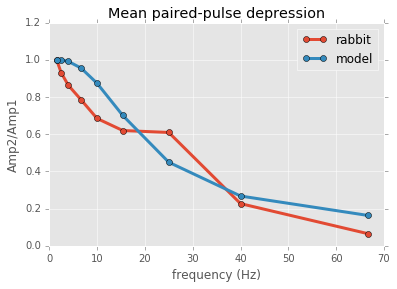

In [29]:
plt.plot(jensen2007['amp2amp1'][:, 0], jensen2007['amp2amp1'][:, 1], 'o-', linewidth=3, label='rabbit')
plt.plot(jensen2007['amp2amp1'][:, 0], exp1['amp2amp1'], 'o-', linewidth=3, label='model')
plt.xlabel('frequency (Hz)')
plt.ylabel('Amp2/Amp1')
plt.title('Mean paired-pulse depression')
plt.legend()

In [22]:
exp2 = run_jensen2007_exp2(model, exp2_freqs)

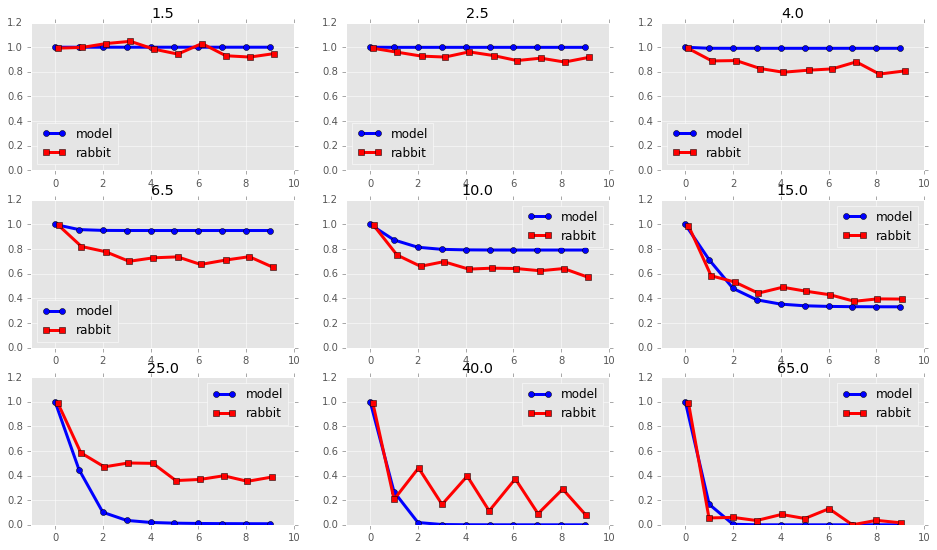

In [28]:
num_cols = np.floor(np.sqrt(len(exp2_freqs)))
num_rows = np.ceil(len(exp2_freqs) / num_cols)
plt.figure(figsize=(16, 9))
for i, freq in enumerate(exp2_freqs):
    cond = '%.1f' % freq
    plt.subplot(num_rows, num_cols, i + 1)
    if 'norm_resp' in exp2[cond]:
        plt.plot(exp2[cond]['norm_resp'], 'o-b',
                 linewidth=3, label='model')
    if cond in jensen2007['norm_resp']:
        plt.plot(jensen2007['norm_resp'][cond][:, 0] - 1,
                 jensen2007['norm_resp'][cond][:, 1], 's-r',
                 linewidth=3, label='rabbit')
    plt.title(cond)
    plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')

In [24]:
exp0 = run_jensen2007_exp0(model)

In [25]:
exp0['resp']

1.0001754548203383

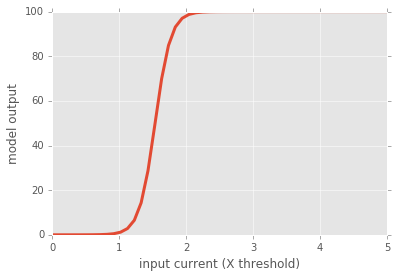

In [36]:
x = np.linspace(0, 5, 50)
y = []
for amp in x:
    exp0 = run_jensen2007_exp0(model, amp)
    y.append(exp0['resp'])
plt.plot(x, y, linewidth=3)
plt.xlabel('input current (X threshold)')
plt.ylabel('model output')